### Pulse Gates

Most quantum algorithms can be described with circuit operations alone. When we need more control over the low-level implementation of our program, we use *pulse gates*. They remove the constraint of executing circuits with basis gates only, and also allow you to override the default implementation of any basis gate. 

They allow you to map a logical circuit gate (e.g. `X`) to a Qiskit Pulse program, called a `Schedule`. This mapping is referred to as a *calibration*. A high fidelity calibrartion is one which faithfully implemenets the logical operation it is mapped from (e.g., whether the `X` gate calibration drives $|0\rangle $ to $|1\rangle$). 

A schedule specifies the exact time dynamics of the input signals across all input *channels* to the device. There are usually multile channels per qubit, such as drive and measure. This interface is more powerful, but requires a deeper understanding of the underlying device physics. 

Pulse programs operation on physical qubits. A drive pulse on qubit $a$ will not enact the same logical operation on qubit $b$, in contrast to an `X` gate acting indpeenent of its qubit operand. 

Let's start with a very simple exmaple, a Bell state circuit

In [19]:
from qiskit import QuantumCircuit

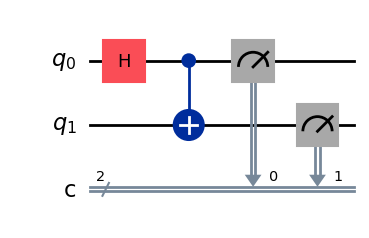

In [20]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)

circ.draw('mpl')

Building calibrations

Let's define a calibration for the Hadamard gate on qubit 0. 

In practice, the pulse shape and its parameters would be optimized via a series of Rabi experiments. For this example, our Hadamard gate will be a Gaussian pulse. We will *play* our pulse on the *drive* channel of qubit 0. 

Don't worry too much about the details of building the calibration itself. 

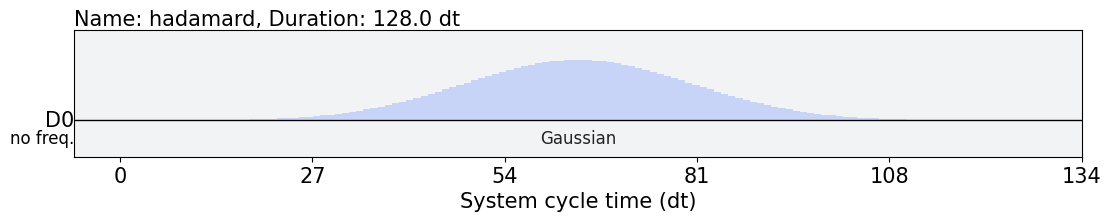

In [29]:
from qiskit import pulse 
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import Fake127QPulseV1

backend = Fake127QPulseV1()

with pulse.build(backend, name = 'hadamard') as h_q0: 
    pulse.play(Gaussian(duration = 128, amp = 0.1, sigma = 16), pulse.drive_channel(0))

h_q0.draw()

In [22]:
circ.add_calibration('h', [0], h_q0)

['id', 'rz', 'sx', 'x', 'cx', 'reset']


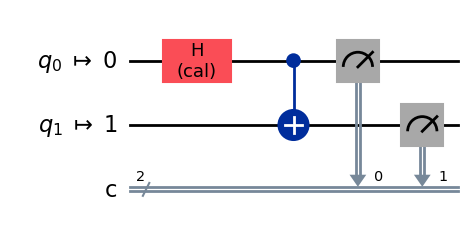

In [23]:
from qiskit import transpile
from qiskit.providers.fake_provider import Fake7QPulseV1

backend = Fake7QPulseV1()

circ = transpile(circ, backend)

print(backend.configuration().basis_gates)
circ.draw('mpl', idle_wires=False)

Note that `h` is not a basis gate for the fake backend. Since we have added a calibration for it, the transpiler will treat our gate as a basis gate; *but only for the qubit 0 it was defined on*. A hadamard applied to a different qubit would be unrolled to its basis gate decomposition. 


#### Custom Gates

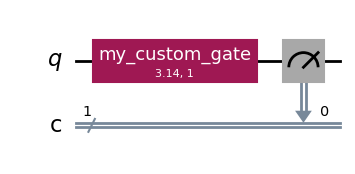

In [35]:
from qiskit.circuit import Gate
from qiskit.providers.fake_provider import FakeOpenPulse2Q

circ = QuantumCircuit(1, 1)
custom_gate = Gate('my_custom_gate', 1, [3.14, 1]) # 3.14 arbitrary parameter

circ.append(custom_gate, [0])
circ.measure(0, 0)

circ.draw('mpl')

In [32]:
with pulse.build(backend, name = 'custom') as my_schedule: 
    pulse.play(Gaussian(duration= 64, amp = 0.2, sigma = 8), pulse.drive_channel(0))

circ.add_calibration('my_custom_gate', [0], my_schedule)

In [36]:
backend = FakeOpenPulse2Q()

circ = transpile(circ, backend)
circ.draw('mpl', idle_wires=False)

TranspilerError: "HighLevelSynthesis was unable to synthesize Instruction(name='my_custom_gate', num_qubits=1, num_clbits=0, params=[3.14, 1])."